<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Lab: Image Classification with HOG and SVM</h1>


Estimated time needed: **60** minutes


## Overview


You will learn how to train a Support Vector Machine (SVM) model using images as input data.
SVM is a supervised learning algorithm that is commonly used for classification and regression tasks. It works by finding the optimal hyperplane that separates data points of different classes with the maximum margin. In this lab, we will use SVM to classify images based on their visual features.


## Objectives


You will classify images using the Histogram of Oriented Gradients (HOG) for feature extraction and Support Vector Machines (SVM) for classification. This traditional computer vision approach was widely used for image classification tasks before the rise of deep learning, and remains a valuable technique for understanding classical ML pipelines.


# Table of Contents


This notebook is organized into the following sections:
        
- [Install and Import Libraries](#Install-and-Import-Libraries)
- [Image Processing](#Image-Processing)
- [Load the Image Annotations](#Load-the-Image-Annotations)
- [H.O.G. as a feature descriptor](#H.O.G.-as-a-feature-descriptor) 
- [Load Images and Generate Training/Testing Dataset](#Load-Images-and-Generate-Training/Testing-Dataset)
- [SVM for Image classification](#SVM-for-Image-classification) 
- [Practice Exercise](#Practice-Exercise)
        


----


# Install and Import Libraries


In [4]:
!pip install --upgrade opencv-python-headless --quiet
!pip install numpy pandas matplotlib seaborn imutils scikit-learn scikit-image joblib --quiet

**Import Important Libraries and Define Auxilary Functions**


Libraries for data processing and visualization:


In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime
import requests
import zipfile
import json
import random

Libraries for image pre-processing and classification:


In [6]:
import cv2
import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

Libraries for OS:


In [7]:
import os
import io

## Image Processing


We will load and process every image. Let's go over some concepts:

<ul>
        <ul>
            <li><code>cv2.resize()</code> to resize the image </li>
            <li><code>cv2.COLOR_BGR2GRAY()</code> will convert the images to greyscale image</li>
            <li><code>hog()</code> will get the H.O.G. features from the image </li>
        </ul>
    
</ul>

We will use the **load_image()** function to read and preprocess the images. The function will be called in the **Histogram of Oriented Gradients (H.O.G.)** section.
It performs the following steps:
<ul>
    <li>Resize the image</li>
Standardizes each image to 64x64 pixels to ensure uniform input dimensions.

<li>Convert to grayscale</li>
Converts the image to grayscale because HOG operates on intensity gradients, not color information.

<li>Extract HOG features</li>
Uses the hog() function to extract Histogram of Oriented Gradients features from the grayscale image.

<li>Retrieve label using annotations</li>
Extracts the image filename.
Looks up the corresponding label from the annotations JSON file.

<li>Convert label to numeric index</li>
Translates the textual label (e.g., 'cat', 'dog') to its numerical index in the class_object list.

<li>Append features and labels</li>
Stores the extracted HOG features and the corresponding numeric label in the train_images and train_labels lists.
</ul>


In [8]:
def load_images(image_paths):
    # loop over the input images with a progress bar
    for image_path in tqdm(image_paths, desc="Loading and processing images"):
        # read image
        image = cv2.imread(image_path)
        if image is None:
            tqdm.write(f"Could not read {image_path}")
            continue

        image = np.array(image).astype('uint8')
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # extract HOG features
        hog_features, hog_images = hog(grey_image,
                                       visualize=True,
                                       block_norm='L2-Hys',
                                       pixels_per_cell=(16, 16))

        # get label using the filename
        filename = os.path.basename(image_path)

        if filename not in annotations["annotations"]:
            tqdm.write(f"Skipping {filename}, not found in annotations.")
            continue

        label = class_object.index(annotations["annotations"][filename][0]['label'])

        train_images.append(hog_features)
        train_labels.append(label)

### Download Your Images and Annotations
We will train and classify them using the SVM classifier using the <code>Sklearn</code> library. Before we start, let's get the images and take a look at some of them.


In [9]:
# URL of the ZIP file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QMmv2Y3pAQe39dV4t0ZJrA/training-an-image-classifier-w-2025-05-22-t-09-51-08-896-z.zip"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the zip file from the downloaded content
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall("cats_dogs")  # Extract to a target folder
    print("Download and extraction complete.")
else:
    print("Failed to download file:", response.status_code)


Download and extraction complete.


In image classification, annotations are labels or metadata that describe what's in an image. These labels are essential for training supervised machine learning models. The annotations will come in a JSON file. What you can see is the image name as the key and dog or cat as label object.

Let's view the format of the annotations we've just downloaded. The following code will display only the first 5 annotations.


In [10]:
# Define the path to the annotations JSON file
annotations_path = "cats_dogs/training-an-image-classifier-w-2025-05-22-t-09-51-08-896-z/_annotations.json"

# Load the JSON file
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Now safely access the first five entries
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five


{'60885f49-c7fd-40e0-a641-248c12f08469.jpg': [{'label': 'cat',
   'id': '8fbdfddf-dda9-4e14-9b5e-c06b02e0a9c2'}],
 '5007a2a5-e79d-45ae-9178-e65b31a850df.jpg': [{'label': 'dog',
   'id': '737ac3fc-bba4-4858-a14a-e722f8d236b8'}],
 '41bd8cfb-71e2-41c1-97e2-29dbeebbdcda.jpg': [{'label': 'dog',
   'id': '9f42588e-9aac-4b78-91c3-36b80293d997'}],
 'd5afbe45-5e93-44b8-b6b6-fe7c45883a01.jpg': [{'label': 'dog',
   'id': '0af09ddb-29a4-4a6d-bb4a-0b5158bacdb7'}],
 '2f424b22-7310-4b13-899f-53f2289972f0.jpg': [{'label': 'cat',
   'id': '5c388dae-0c8f-4e08-922c-48a152349f1a'}]}

# Load the Image Annotations


In [11]:
# Define base folder path
base_folder = "cats_dogs/training-an-image-classifier-w-2025-05-22-t-09-51-08-896-z"

# Path to the annotations JSON file
annotations_path = os.path.join(base_folder, "_annotations.json")

# Load the JSON data
with open(annotations_path, "r") as f:
    annotations = json.load(f)

print("Annotations loaded successfully!")

Annotations loaded successfully!


## H.O.G. as a feature descriptor


H.O.G. generates a histogram for each localized region. We will pick a random image and see how H.O.G. works.


In [12]:
# Pick a random image from the annotations
random_image_name = random.choice(list(annotations["annotations"].keys()))

# Get the label for that image
label = annotations["annotations"][random_image_name][0]["label"]

print(f"Random image selected: {random_image_name}")
print(f"Label: {label}")

Random image selected: 5aa6eaff-8768-406a-8d5d-88e4b1129a47.jpg
Label: cat


Construct full path to image


In [13]:
# Construct full path to image
image_path = os.path.join(base_folder, random_image_name)

# Read image using OpenCV
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
print("Full image path:", image_path)


Full image path: cats_dogs/training-an-image-classifier-w-2025-05-22-t-09-51-08-896-z/5aa6eaff-8768-406a-8d5d-88e4b1129a47.jpg


To create H.O.G. features, we will first convert the image to a grayscale image.


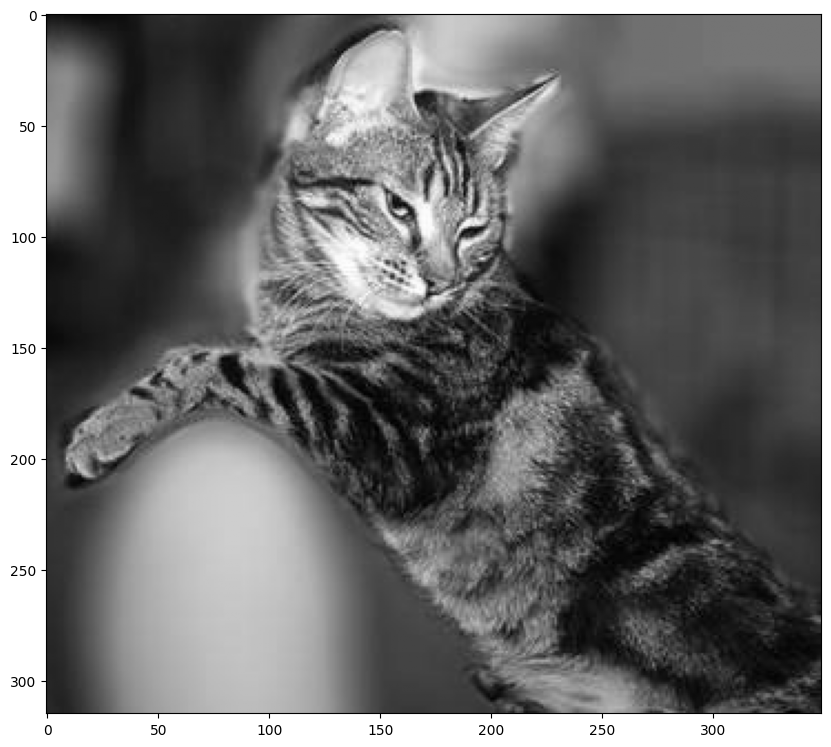

In [14]:
sample_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(sample_image, cmap = "gray")
plt.show()

Resize the image to a smaller size to allow the algorithm to run faster and convert the images to the grayscale to reduce the number of channels. `OpenCV` reads images as `BGR` so we will be using that color channel to convert to grayscale. 

Early developers at `OpenCV` chose `BGR` color format because it was the format that was popular among camera manufacturers and software providers.


In [15]:
sample_image = cv2.resize(img, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

Plot the data to look at what it looks like:


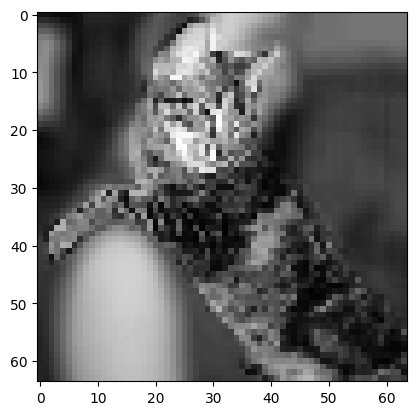

In [16]:
plt.imshow(sample_image, cmap=plt.cm.gray)

Run H.O.G. on the grayscale image to see what it will look like.

H.O.G. stands for Histogram of Oriented Gradients. It uses the gradient orientation of the localized regions of an image and generates a histogram for each localized region.


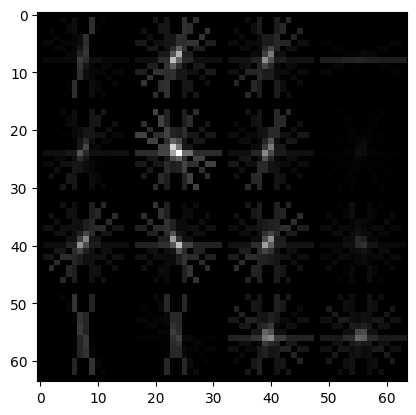

In [17]:
## when we run H.O.G., it returns an array of features and the image/output it produced
## the featurre is what we use to train the SVM model
sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## lets look at what the H.O.G. feature looks like
plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


Initiate a location for saving loaded images:


In [18]:
image_paths = list(paths.list_images(base_folder))
train_images = []
train_labels = []
class_object = annotations['labels']

Use the function on the image path:


In [19]:
load_images(image_paths)

Loading and processing images: 100%|██████████| 1000/1000 [00:20<00:00, 47.99it/s]


In [20]:
print(f"Number of images: {len(train_images)}")
print(f"Number of labels: {len(train_labels)}")


Number of images: 1000
Number of labels: 1000


Create an array of the images and use the <code>np.vstack</code> to vertically stack arrays for wrangling.


In [21]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

We will <code>reshape</code> the array to <code>(label size, 1)</code>. The array will look like this: <code>[[1], [0], ..., [0]]</code></p>


In [22]:
labels_array = np.array(train_labels)

In [23]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

Concatenate the images and labels:


In [24]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

Divide the data into a training and test set:


In [25]:
percentage = 70
partition = int(len(train_df)*percentage/100)

In [26]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

### Hyperparameters


The kernel type to be used is a hyperparameter. The most common kernels are <code>RBF</code>, <code>poly</code>, or <code>sigmoid</code>. You can also create your own kernel.

<code>C</code> behaves as a regularization parameter in the SVM. The <code>C</code> parameter trades off correct classification of the training examples against the maximization of the decision function’s margin. For larger values of <code>C</code>, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower <code>C</code> will encourage a larger margin, therefore a simpler decision function at the cost of accuracy. We select C and the best kernel by using the validation data. 


The  python dictionary <code>param_grid</code>  has different kernels and values of C. We can test them using the validation data.


In [27]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

<code>gamma</code> is a parameter of the RBF kernel and can be thought of as the spread of the kernel and, therefore, the decision region. Low values mean ‘far’ and high values mean ‘close’. The behaviour of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself. We create a Support Vector Classification object.


## SVM for Image classification


In [28]:
base_estimator = SVC(gamma='scale')

We will train the model and try different kernels and parameter values using the function <code>GridSearchCV</code>. The resulting output will be the model that performs best on the validation data. 


In [29]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

{'C': 10, 'kernel': 'rbf'}
Accuracy: 1.0
0.9579441547393799


**A Quick Guide to the Confusion Matrix**


A confusion matrix is a performance measurement for a classification problem. It is a table with a combination of predicted and actual values. On the y-axis, we have the `True` label and on the x-axis we have the `Predicted` label. This example will focus on a binary classifier, i.e. a yes or no model.

<table>
  <tr>
    <td>&nbsp;</td>
    <td>Predicted: NO</td>
    <td>Predicted: YES</td>
  </tr>
  <tr>
    <td>True: NO</td>
    <td>30</td>
    <td>30</td>
  </tr>
  <tr>
    <td>True: YES</td>
    <td>10</td>
    <td>50</td>
  </tr>
</table>

In this matrix, we can see that there are two classes. For example, if we were predicting if an image is a hotdog, "yes" will be that it is a hotdog and "no" will be that it is not a hotdog. We have 120 predictions and out of those times, the classifier predicted "yes" 80 times and "no" 40 times but really, there were 60 "yes"s and 60 "no"s.

When we talk about confusion matrix, we talk about a few terms:
* True Positive (TP): Our model predicted "yes", and it was actually "yes"
* True Negative (TN): Our model predicted "no", and it was actually "no"
* False Positive (FP): Our model predicted "yes", but it was actually "no"
* False Negative (FN): Our model predicted "no", but it was actually "yes"

Let's look at it in the context of our example:

<table>
  <tr>
    <td>&nbsp;</td>
    <td>Predicted: NO</td>
    <td>Predicted: YES</td>
  </tr>
  <tr>
    <td>True: NO</td>
    <td>TN = 30</td>
    <td>FP = 30</td>
    <td>60</td>
  </tr>
  <tr>
    <td>True: YES</td>
    <td>FN = 10</td>
    <td>TP = 50</td>
    <td>60</td>
  </tr>
  <tr>
    <td>&nbsp;</td>
    <td>40</td>
    <td>80</td>
  </tr>
</table>

**Accuracy** is the number the model got right over the total number of predictions. This is (TP+TN)/Total Number of Predictions.


Get Confusion Matrix for SVM results:


In [30]:
label_names = [0, 1]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

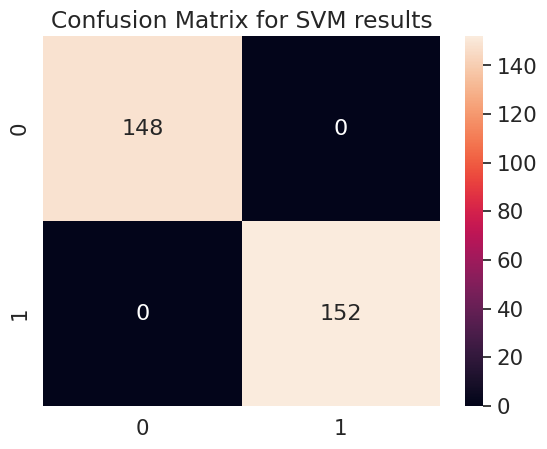

In [31]:
# Convert the confusion matrix array into a pandas DataFrame for easier plotting
df_cm = pd.DataFrame(cmx)

# Optional: set font scale for Seaborn heatmap labels (e.g., axis labels and annotations)
sns.set(font_scale=1.4)  # Increases the font size for better readability

# Plot the confusion matrix using a heatmap
# - annot=True enables showing the numeric values inside the cells
# fmt="d" forces integer display
# - annot_kws controls the annotation text size
sns.heatmap(df_cm, annot=True, fmt="d",annot_kws={"size": 16})

# Set the plot title to indicate this is the confusion matrix for SVM classification
title = "Confusion Matrix for SVM results"
plt.title(title)

# Display the plot
plt.show()


In [32]:
# Save the SVM model to a file
joblib.dump(svm.best_estimator_, 'svm.joblib')

['svm.joblib']

# Practice Exercise
### Test Our Model with an Uploaded Image


Upload your image, and see if it will be correctly classified.
<p><b>Instructions on How to Upload an Image:</b></p>
Use the upload button and upload an image from your local machine:
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/instruction.png" width="300"  />
</center>


The image will now be in the directory in which you are working in. To read the image in a new cell, use the <code>cv2.imread</code> and read its name. For example, I uploaded <code>anothercar.jpg</code> into my current working directory - <code>cv2.imread("anothercar.jpg")</code>.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/instruction2.png" width="300"  />
</center>


Else use the below images to test.


In [33]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/A3xVgxTJVdrZTtBwGVbEIw/Cat.jpg"
!wget"https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KZnFQiZj3e_sQKIyfvHvTA/dog.jpg"


--2026-01-13 22:28:47--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/A3xVgxTJVdrZTtBwGVbEIw/Cat.jpg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
200 OKequest sent, awaiting response... 
Length: 188980 (185K) [image/jpeg]
Saving to: ‘Cat.jpg.3’

Cat.jpg.3           100%[===================>] 184.55K  --.-KB/s    in 0.004s  

2026-01-13 22:28:47 (41.4 MB/s) - ‘Cat.jpg.3’ saved [188980/188980]

/bin/bash: line 1: wgethttps://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KZnFQiZj3e_sQKIyfvHvTA/dog.jpg: No such file or directory


Load the model


In [34]:
svm_model = joblib.load('svm.joblib')

Replace your_uploaded_file below with the name of your image as seen in your directory. In case you are using the downloaded images given in the notebook then use as `Cat.jpg` or `dog.jpg`


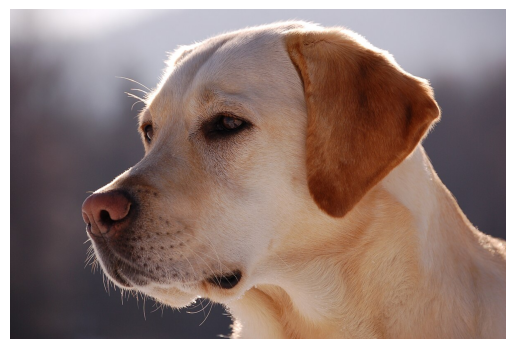

In [36]:
my_image = cv2.imread("dog.jpg")
## let's see what the image looks like
image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

Image Preprocessing and HOG Feature Extraction


In [37]:

# Check if image is loaded
if image is None:
    raise ValueError("Image not found or path is incorrect.")

# Resize and convert to grayscale
image = cv2.resize(image, (64, 64))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Extract HOG features
hog_features, hog_image = hog(gray,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# Convert to appropriate shape for prediction
hog_features = np.array([hog_features])  # Shape: (1, N)


Image Classification using Pre-trained SVM Model


In [38]:
# Predict using the loaded model
predicted_label_index = svm_model.predict(hog_features)[0]

# Convert to integer for list indexing
predicted_label = annotations["labels"][int(predicted_label_index)]

print(f"The image was classified as: {predicted_label}")


The image was classified as: dog


Display the HOG image


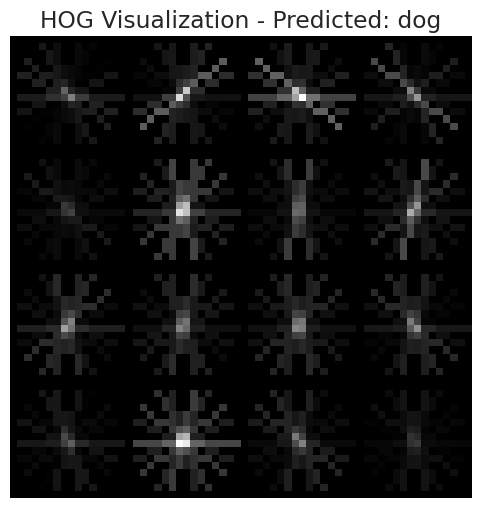

In [39]:
# Display the HOG image
plt.figure(figsize=(6, 6))
plt.imshow(hog_image, cmap='gray')
plt.title(f"HOG Visualization - Predicted: {predicted_label}")
plt.axis("off")
plt.show()

This visualization illustrates how the model interprets the image using HOG (Histogram of Oriented Gradients) features for classification.

The grid of black and white cells represents localized gradient information in different regions of the image.

Each bright line or orientation within a cell indicates the direction and strength of edges detected in that part of the image.

The brighter the region, the stronger the edge or gradient detected in that direction.


## Congratulations!

You've successfully completed a full image classification pipeline using the Support Vector Machine (SVM) algorithm and OpenCV! 


<h2>Authors</h2>


 [Aije Egwaikhide](https://www.linkedin.com/in/aije-egwaikhide/)

 [Sathya Priya](https://www.linkedin.com/in/sathya-priya-06120a17a/) 


<!--<h2>Change Log</h2>-->


<!--<table>
    <tr>
        <th>Date (YYYY-MM-DD)</th>
        <th>Version</th>
        <th>Changed By</th>
        <th>Change Description</th>
    </tr>
    </tr>
        <tr>
        <td>2025-06-25</td>
        <td>1.3</td>
        <td>Sathya</td>
        <td>Created and Converted the lab to JupyterCurrent notebook</td>
    </tr>
    <tr>
        <td>2021-05-25</td>
        <td>1.2</td>
        <td>Kathy</td>
        <td>Modified multiple areas</td>
    </tr>
    <tr>
        <td>2021-05-25</td>
        <td>1.2</td>
        <td>Yasmine</td>
        <td>Modified multiple areas</td>
    </tr>
     <tr>
        <td>2021-04-10</td>
        <td>1.1</td>
        <td>Aije</td>
        <td>Fixed grammatical errors</td>
    </tr>
    <tr>
        <td>2021-04-09</td>
        <td>1.0</td>
        <td>Aije</td>
        <td>Updated to new template</td>
    </tr>
    <tr>
        <td>2021-02-24</td>
        <td>0.1</td>
        <td>Aije</td>
        <td>Created original version of the lab</td>
    </tr>
</table>-->


<h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
